---
## LUISS 'Guido Carli'  
A.Y. 2023-24 - MSc in Data Science and Management   
Course: Python and R for Data Science  
### Final project submission  
Coci Marco (786471) - Cecere Rachele (775701) - Isayas Aida (772631) - Marchioni Gian Lorenzo (788811)

---



# OSEMN pipeline: UFC matches dataset
The dataset, taken from [kaggle](https://www.kaggle.com/datasets/rajeevw/ufcdata), records matches held from 1993, when the UFC was founded, up to 2021.  

After scrubbing, exploration and due preprocessing, we will train a logistic regression model to predict a match outcome based on physical features of fighters and also some past performance indicators and statistics.

In this python notebook we will focus more on the scrubbing, exploration and visualization of the dataset. The submitted R notebook will instead delve more in depth into modeling.

Each fighter is denoted by the color of its corner, Red or Blue, which is not randomly assigned at the match but decided by the UFC beforehand.

From the link we have taken two files:
- `data.csv`
- `raw_total_fight_data.csv`

The first contains processed data and fighters statistics upated for each match.

Then, to help identify the most relevant features, we use the second dataset taken from the same author, where the win criteria for each match is recorded.  
Knowing whether the matches are most often won by KO, judging or other ways may
provide additional insights on what performance indicators are the most relevant.

In [4]:
# Downloading the libraries that we will need
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import missingno as msno
from pandas.plotting import scatter_matrix

# Obtaining the data
Dataset loading and feature selection.

We will first load the processed dataset that will be used for most of the exploration and modeling.
It is comprised of a large number of features: 144 columns, most of them are duplicates since features for Red and Blue fighters are listed separately, which is not a tidy format.

It is already possible to see some `NaN`s in the `avg_KD columns`

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv("/content/drive/My Drive/Python Proj/data.csv")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,NaN,NaN,...,0,0,0,0,Southpaw,190.50,NaN,260.0,NaN,NaN
6008,Orlando Wiet,Robert Lucarelli,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,NaN,NaN,...,0,0,0,0,Southpaw,177.80,NaN,170.0,NaN,NaN
6009,Johnny Rhodes,David Levicki,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,NaN,NaN,...,0,0,0,0,Orthodox,182.88,NaN,210.0,NaN,NaN
6010,Patrick Smith,Ray Wizard,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,OpenWeight,NaN,NaN,...,0,0,0,0,Orthodox,187.96,NaN,225.0,NaN,30.0


We will then load the raw fights dataset.  
Note the `win_by` column, whose categorical entries will be grouped, counted and plotted.

In [6]:
#we also uploaded here this additional dataset that contains the method of takedown that help us to know how the metches usually finish
df1 = pd.read_csv("/content/drive/MyDrive/Python Proj/raw_total_fight_data.csv", delimiter=';')
df1

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Adrian Yanez,Gustavo Lopez,2,0,41 of 103,23 of 51,39%,45%,41 of 103,23 of 51,...,0 of 0,KO/TKO,3,0:27,3 Rnd (5-5-5),Chris Tognoni,"March 20, 2021","Las Vegas, Nevada, USA",Bantamweight Bout,Adrian Yanez
1,Trevin Giles,Roman Dolidze,0,0,27 of 57,32 of 67,47%,47%,43 of 73,75 of 110,...,1 of 2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Middleweight Bout,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,1,0,14 of 18,2 of 6,77%,33%,14 of 18,2 of 6,...,0 of 0,KO/TKO,1,0:49,3 Rnd (5-5-5),Herb Dean,"March 20, 2021","Las Vegas, Nevada, USA",Heavyweight Bout,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,0,0,31 of 65,15 of 41,47%,36%,49 of 87,136 of 168,...,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Strawweight Bout,Montserrat Conejo
4,Marion Reneau,Macy Chiasson,0,0,30 of 63,51 of 138,47%,36%,59 of 93,92 of 184,...,2 of 4,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"March 20, 2021","Las Vegas, Nevada, USA",Women's Bantamweight Bout,Macy Chiasson
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,0,0,4 of 6,1 of 3,66%,33%,20 of 22,9 of 11,...,0 of 2,Submission,1,9:51,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Remco Pardoel
6008,Orlando Wiet,Robert Lucarelli,0,0,8 of 12,2 of 6,66%,33%,11 of 15,2 of 6,...,0 of 0,KO/TKO,1,2:50,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Orlando Wiet
6009,Johnny Rhodes,David Levicki,0,0,11 of 17,4 of 5,64%,80%,74 of 86,95 of 102,...,1 of 1,KO/TKO,1,12:13,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Johnny Rhodes
6010,Patrick Smith,Ray Wizard,0,0,1 of 1,1 of 1,100%,100%,1 of 1,2 of 2,...,0 of 0,Submission,1,0:58,No Time Limit,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Open Weight Bout,Patrick Smith


## Understanding Column Meanings
By printing the column names and using the legend provided on the kaggle page, we can interpret the more 'cryptic' columns:
- `R` and `B` prefix signifies red and blue corner fighter stats
- `avg` indicates the average over a fighters past matches, up to the recorded one
- `landed` denotes actions or strikes completed successfully
- `attempted` denotes unsuccessful or weak actions or strikes
- `pct` indicates the ratio of landed over attempted
- `opp` containing columns is the average of damage done by the opponent on the fighter
- `KD`: number of knockdowns
- `SIG_STR`: significant strikes
- `TOTAL_STR`: total strikes
- `TD`: takedowns
- `SUB_ATT`: submission attempts
- `HEAD`: significant strikess to the head
- `BODY`: significant strikes to the body
- `CLINCH`: significant strikes in the clinch
- `GROUND`: significant strikes on the ground
- `total_rounds_fought`: average of total rounds fought by the fighter

In [7]:
df.columns.values

array(['R_fighter', 'B_fighter', 'Referee', 'date', 'location', 'Winner',
       'title_bout', 'weight_class', 'B_avg_KD', 'B_avg_opp_KD',
       'B_avg_SIG_STR_pct', 'B_avg_opp_SIG_STR_pct', 'B_avg_TD_pct',
       'B_avg_opp_TD_pct', 'B_avg_SUB_ATT', 'B_avg_opp_SUB_ATT',
       'B_avg_REV', 'B_avg_opp_REV', 'B_avg_SIG_STR_att',
       'B_avg_SIG_STR_landed', 'B_avg_opp_SIG_STR_att',
       'B_avg_opp_SIG_STR_landed', 'B_avg_TOTAL_STR_att',
       'B_avg_TOTAL_STR_landed', 'B_avg_opp_TOTAL_STR_att',
       'B_avg_opp_TOTAL_STR_landed', 'B_avg_TD_att', 'B_avg_TD_landed',
       'B_avg_opp_TD_att', 'B_avg_opp_TD_landed', 'B_avg_HEAD_att',
       'B_avg_HEAD_landed', 'B_avg_opp_HEAD_att', 'B_avg_opp_HEAD_landed',
       'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_opp_BODY_att',
       'B_avg_opp_BODY_landed', 'B_avg_LEG_att', 'B_avg_LEG_landed',
       'B_avg_opp_LEG_att', 'B_avg_opp_LEG_landed', 'B_avg_DISTANCE_att',
       'B_avg_DISTANCE_landed', 'B_avg_opp_DISTANCE_att',
       'B_a

In [8]:
df1.columns.values

array(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR.',
       'B_SIG_STR.', 'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.',
       'B_TOTAL_STR.', 'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct',
       'R_SUB_ATT', 'B_SUB_ATT', 'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL',
       'R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG',
       'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH', 'R_GROUND',
       'B_GROUND', 'win_by', 'last_round', 'last_round_time', 'Format',
       'Referee', 'date', 'location', 'Fight_type', 'Winner'],
      dtype=object)

Printing out unique values and type of `win_by`:

In [9]:
print(df1['win_by'].unique())
print(df1['win_by'].describe())

['KO/TKO' 'Decision - Unanimous' 'Decision - Split' 'Could Not Continue'
 'Submission' 'DQ' 'Decision - Majority' "TKO - Doctor's Stoppage"
 'Overturned' 'Other']
count                     6012
unique                      10
top       Decision - Unanimous
freq                      2097
Name: win_by, dtype: object


'`Fight_type`' describes what type of match or event was recorded. It will also be relevant further on.

Below we review information about the data types,columns, null value counts, memory usage.  
While we have yet to select feature of interest from the long list, at first glance the columns that should intuitively contain numeric values have correct type, either `float` or `int`.  
Only the `date` column seems to be incorrectly typed as `object`.

In [10]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 144 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    R_fighter                     object 
 1    B_fighter                     object 
 2    Referee                       object 
 3    date                          object 
 4    location                      object 
 5    Winner                        object 
 6    title_bout                    bool   
 7    weight_class                  object 
 8    B_avg_KD                      float64
 9    B_avg_opp_KD                  float64
 10   B_avg_SIG_STR_pct             float64
 11   B_avg_opp_SIG_STR_pct         float64
 12   B_avg_TD_pct                  float64
 13   B_avg_opp_TD_pct              float64
 14   B_avg_SUB_ATT                 float64
 15   B_avg_opp_SUB_ATT             float64
 16   B_avg_REV                     float64
 17   B_avg_opp_REV                 float64
 18   B_avg_

We are just interested in the `win_by` column of the raw dataset.  
However, it is possible to notice that many quantitative variables here, like the number or percentage of significant strikes (`SIG_STR`) are incorrectly typed as `object`, further confirmation that the main dataset stored in `data.csv` has already been processed to some extent.

In [11]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   R_fighter        6012 non-null   object
 1   B_fighter        6012 non-null   object
 2   R_KD             6012 non-null   int64 
 3   B_KD             6012 non-null   int64 
 4   R_SIG_STR.       6012 non-null   object
 5   B_SIG_STR.       6012 non-null   object
 6   R_SIG_STR_pct    6012 non-null   object
 7   B_SIG_STR_pct    6012 non-null   object
 8   R_TOTAL_STR.     6012 non-null   object
 9   B_TOTAL_STR.     6012 non-null   object
 10  R_TD             6012 non-null   object
 11  B_TD             6012 non-null   object
 12  R_TD_pct         6012 non-null   object
 13  B_TD_pct         6012 non-null   object
 14  R_SUB_ATT        6012 non-null   int64 
 15  B_SUB_ATT        6012 non-null   int64 
 16  R_REV            6012 non-null   int64 
 17  B_REV            6012 non-null   

## Feature selection
UFC, as many martial arts competition, has fighters divided in weight classes.
We will focus our attention on a single weight class, in order to train and test the model on a particular group of fighters whose physical characteristics are comparable.

We will select weight class based on the number of disputed matches, in order to have as large of a final dataset as possible.

The most straightforward way is to group by the '`weight_class`' column in '`df`' and count entries:

In [12]:
#  we defined a color palette in Python using hexadecimal color codes
custom_palette = [
    "#ffd4fd",  # Light Pink
    "#ff7bef",  # Bright Pink
    "#fc8eb8",  # Additional Pink Shade
    "#ff00f4",  # Vibrant Pink
    "#ffb6c1",  # Light Pink (Lighter)
    "#ff69b4",  # Hot Pink
    "#ff1493",  # Deep Pink
    "#f08080",  # Light Coral Pink
    "#db7093",  # Pale Violet Red (Pink Tone)
    "#c71585",  # Medium Violet Red (Pink Tone)
    "#ffafd7",  # Soft Pink
    "#f4c2c2",  # Baby Pink
    "#e75480",  # Dark Pink
]

Weight classes:
['Bantamweight' 'Middleweight' 'Heavyweight' 'WomenStrawweight'
 'WomenBantamweight' 'Lightweight' 'Welterweight' 'Flyweight'
 'LightHeavyweight' 'Featherweight' 'WomenFlyweight' 'WomenFeatherweight'
 'CatchWeight' 'OpenWeight']
Total matches disputed for each weight class:
weight_class
Bantamweight           475
CatchWeight             54
Featherweight          551
Flyweight              230
Heavyweight            585
LightHeavyweight       573
Lightweight           1091
Middleweight           813
OpenWeight              86
Welterweight          1083
WomenBantamweight      151
WomenFeatherweight      16
WomenFlyweight         112
WomenStrawweight       192
dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Bantamweight'),
  Text(1, 0, 'Middleweight'),
  Text(2, 0, 'Heavyweight'),
  Text(3, 0, 'WomenStrawweight'),
  Text(4, 0, 'WomenBantamweight'),
  Text(5, 0, 'Lightweight'),
  Text(6, 0, 'Welterweight'),
  Text(7, 0, 'Flyweight'),
  Text(8, 0, 'LightHeavyweight'),
  Text(9, 0, 'Featherweight'),
  Text(10, 0, 'WomenFlyweight'),
  Text(11, 0, 'WomenFeatherweight'),
  Text(12, 0, 'CatchWeight'),
  Text(13, 0, 'OpenWeight')])

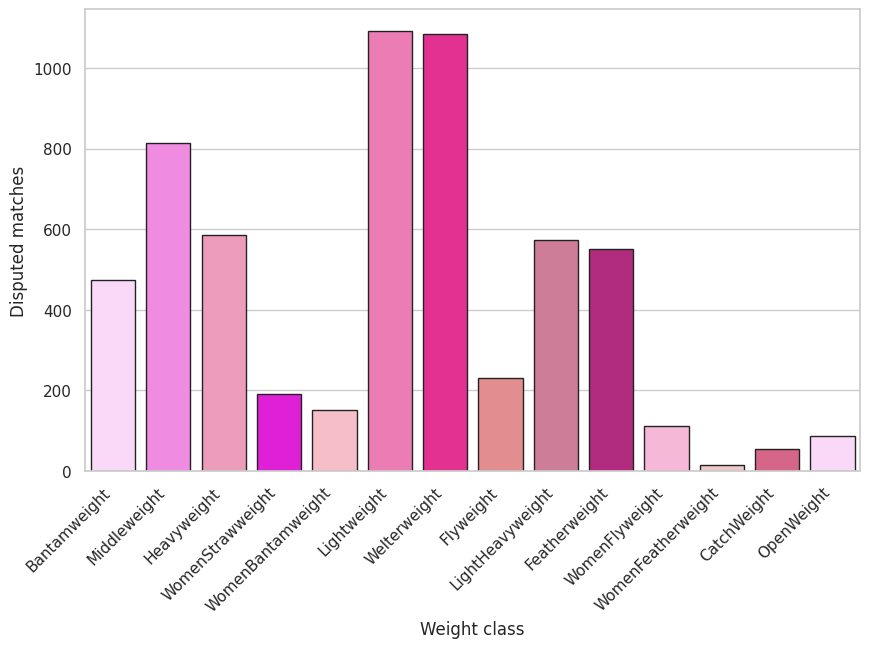

In [13]:
print('Weight classes:')
print(df['weight_class'].unique())
print('Total matches disputed for each weight class:')
print(df.groupby(by='weight_class').size())
plt.figure(figsize=(10, 6))

sns.set_theme(style='whitegrid')

sns.countplot(x='weight_class', data=df, palette=custom_palette, edgecolor='#222222')
plt.xlabel('Weight class')
plt.ylabel('Disputed matches')
plt.xticks(rotation=45, ha='right')

# plt.savefig('weight_class_hist.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

Below we also include a pie plot:

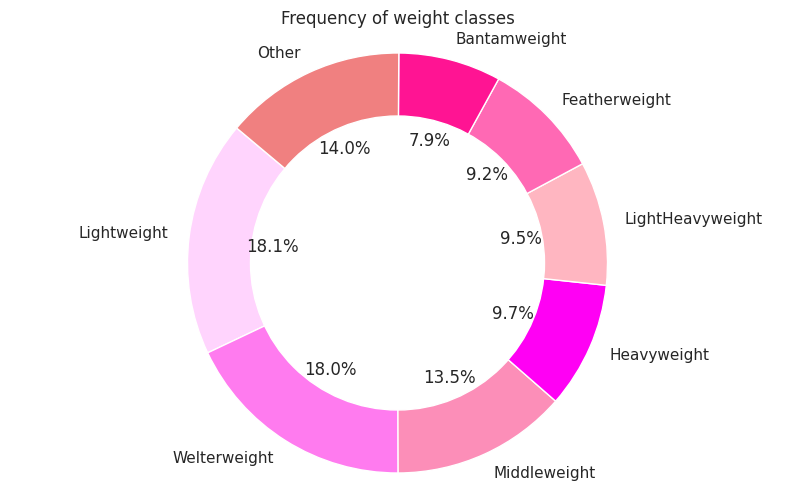

In [14]:
weight_class_counts = df['weight_class'].value_counts()
threshold = 0.05
other = weight_class_counts[weight_class_counts / weight_class_counts.sum() < threshold].sum()
weight_class_counts = weight_class_counts[weight_class_counts / weight_class_counts.sum() >= threshold]
weight_class_counts['Other'] = other

plt.figure(figsize=(10, 6))
plt.pie(weight_class_counts, labels=weight_class_counts.index, autopct='%1.1f%%', colors=custom_palette, startangle=140)
plt.title('Frequency of weight classes')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.savefig('weight_class_pie.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

The weight class with the most matches, and therefore data, is lightweights.
Therefore, from now on we will focus our exploration on those matches.

Let us first plot the frequency of win types in matches, in order to identify a useful subset of features in the processed dataset.  

To do this in the raw dataset, since it has no explicit weight class column, we will need to grep the string 'lightweight' from the '`Fight_type`' column, that, as stated earlier, describes what type of match or event was recorded:

In [15]:
print('Match types:')
print(df1['Fight_type'].unique())

Match types:
['Bantamweight Bout' 'Middleweight Bout' 'Heavyweight Bout'
 "Women's Strawweight Bout" "Women's Bantamweight Bout" 'Lightweight Bout'
 'Welterweight Bout' 'Flyweight Bout' 'Light Heavyweight Bout'
 'Featherweight Bout' "Women's Flyweight Bout"
 'UFC Bantamweight Title Bout' 'UFC Light Heavyweight Title Bout'
 "UFC Women's Featherweight Title Bout" 'UFC Welterweight Title Bout'
 'Catch Weight Bout' 'UFC Flyweight Title Bout'
 "UFC Women's Flyweight Title Bout" 'UFC Lightweight Title Bout'
 'UFC Middleweight Title Bout' 'UFC Heavyweight Title Bout'
 'UFC Featherweight Title Bout' 'UFC Interim Lightweight Title Bout'
 "UFC Women's Strawweight Title Bout" "Women's Featherweight Bout"
 "UFC Women's Bantamweight Title Bout"
 'UFC Interim Middleweight Title Bout'
 'Ultimate Fighter 28 Heavyweight Tournament Title Bout'
 "Ultimate Fighter 28 Women's Featherweight Tournament Title Bout"
 'Ultimate Fighter 27 Featherweight Tournament Title Bout'
 'Ultimate Fighter 27 Lightweight To

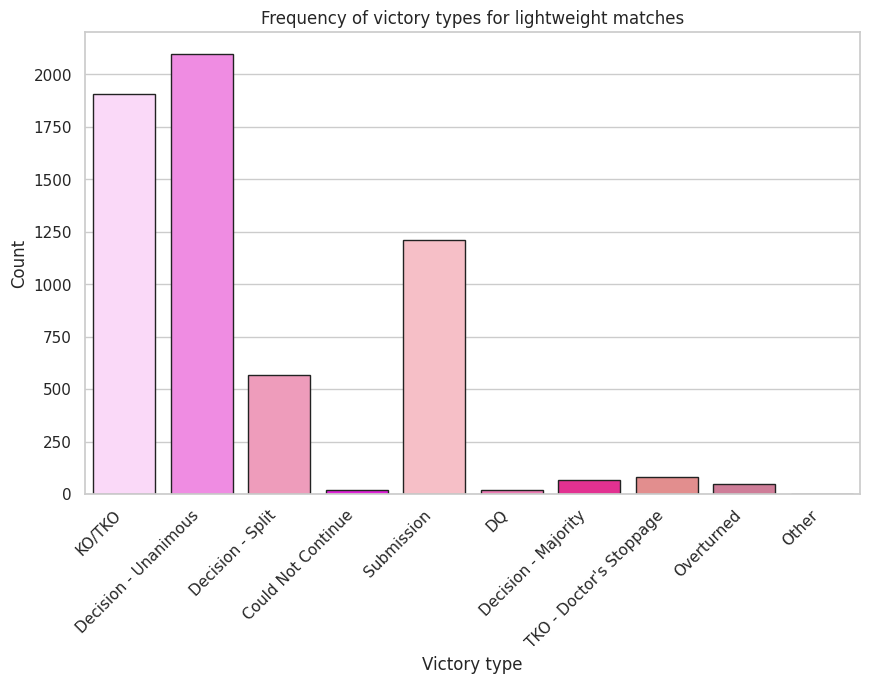

In [16]:
#this graph shows how the fight are usually win from the fighter and for do it we are using another dataset
lightweights_df1 = df1[df1['Fight_type'].str.contains('lightweight', case=False)]

plt.figure(figsize=(10, 6))
sns.countplot(data=df1, x='win_by', palette=custom_palette, edgecolor='#222222')
plt.title('Frequency of victory types for lightweight matches')
plt.xlabel('Victory type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.savefig('win_type_hist.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

Let us also display a pie chart with percentages of victory types.  
We will group together entries with a percentage lower that 5% to make the plot more orderly.

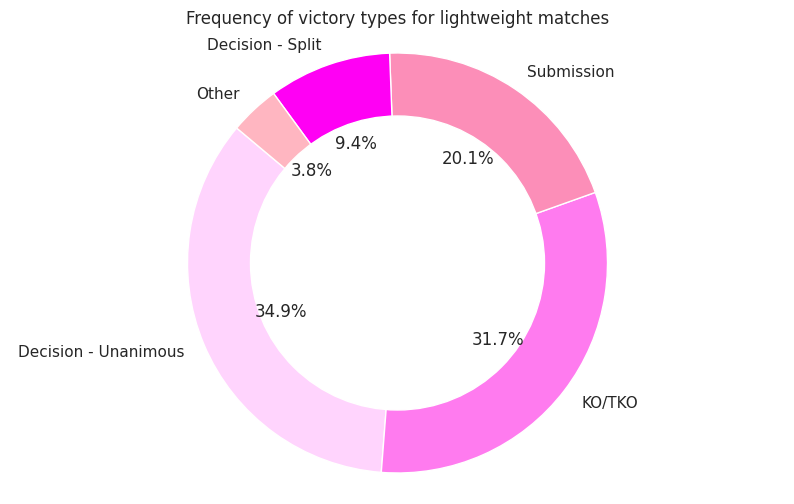

In [17]:
win_by_counts = df1['win_by'].value_counts()
threshold = 0.05
other = win_by_counts[win_by_counts / win_by_counts.sum() < threshold].sum()
win_by_counts = win_by_counts[win_by_counts / win_by_counts.sum() >= threshold]
win_by_counts['Other'] = other

plt.figure(figsize=(10, 6))
plt.pie(win_by_counts, labels=win_by_counts.index, autopct='%1.1f%%', colors=custom_palette, startangle=140)
plt.title('Frequency of victory types for lightweight matches')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')

plt.savefig('win_type_pie.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

It is clear than that most fight end by KO, Judge decision or submission.  
From this we can desume that features that are most likely to influence victories, beside physical characteristics, are performance indicators such as:
- Number of significant strikes landed: judges determine a winner by counting the number of strikes landed
- Number of strikes to the head landed: likely to knock-out an athlete
- Number of take downs, knock-downs: throwing the opponent to the floor successfully may lead to a submission.

We also included variables that take into account:
- Victories and losses amount
- Victory and loss streaks
- Amount of rounds fought

Since within a single weight class weight variation is small, as far tas biometric information we considered:
- Height: in cm
- Reach: arm length, in cm
- Age
Therefore, the selected features for both Red and Blue fighters are the following:

In [18]:
lightweights_df = df[['R_fighter', 'B_fighter', 'Winner', 'weight_class','date',
                       'B_total_rounds_fought', 'B_current_win_streak', 'B_current_lose_streak', 'B_wins', 'B_longest_win_streak', 'B_losses',
                       'B_Height_cms', 'B_Reach_cms', 'B_age',
                       'B_avg_SIG_STR_landed', 'B_avg_HEAD_landed', 'B_avg_KD', 'B_avg_TD_landed',
                       'R_total_rounds_fought', 'R_current_win_streak', 'R_current_lose_streak', 'R_wins', 'R_longest_win_streak', 'R_losses',
                       'R_Height_cms', 'R_Reach_cms', 'R_age',
                       'R_avg_SIG_STR_landed','R_avg_HEAD_landed','R_avg_KD','R_avg_TD_landed']][df['weight_class']=='Lightweight']

Let us now convert the '`date`' column to a date type

In [39]:
lightweights_df['date']=pd.to_datetime(lightweights_df['date'])

The `.describe()` tells us a summary of descriptive statistics for numeric columns in a DataFrame such as count, mean, std...  
This shows ass the number of value that we have,
It doesn't work with any categorical values which are ignored:

In [38]:
lightweights_df.describe().T

,count,mean,std,min,25%,50%,75%,max
B_total_rounds_fought,1091.0,10.141155,13.004454,0.00,1.000000,6.000000,14.000000,86.000000
B_current_win_streak,1091.0,0.841430,1.308956,0.00,0.000000,0.000000,1.000000,7.000000
B_current_lose_streak,1091.0,0.430797,0.676964,0.00,0.000000,0.000000,1.000000,5.000000
B_wins,1091.0,2.692942,3.604551,0.00,0.000000,1.000000,4.000000,23.000000
B_longest_win_streak,1091.0,1.626031,1.760270,0.00,0.000000,1.000000,3.000000,8.000000
B_losses,1091.0,1.656279,2.110721,0.00,0.000000,1.000000,2.000000,14.000000
B_Height_cms,1087.0,176.746145,4.891668,160.02,172.720000,177.800000,180.340000,193.040000
B_Reach_cms,932.0,181.471009,5.593063,162.56,177.800000,180.340000,185.420000,203.200000
B_age,1062.0,28.625235,3.673894,18.00,26.000000,28.500000,31.000000,40.000000
B_avg_SIG_STR_landed,828.0,32.652425,20.632936,0.00,18.000000,30.000000,43.375000,131.739330


Lightweights has indeed 1091 entries, however some have NaN.  
Some scrubbing will need to be performed in the following section.

For many features the reported minimum is zero, which however cannot be infereed to be a NaN.  
It is plausible that a fighter has no recorded victories, losses, or that he was not able to land significant strikes or other actions in previous matches.

We will also discuss potential differences in distributions between Red and Blue fighters in a dedicated EDA section.

# Scrubbing
Here, we review missing information in our dataset to make sure that it will not impact the results of our exploration.

Let us first count the NaN values for each feature:

In [37]:
missing_values = lightweights_df.isnull().sum()

print("Missing Values Summary:")
print(missing_values)

Missing Values Summary:
R_fighter                  0
B_fighter                  0
Winner                     0
weight_class               0
date                       0
B_total_rounds_fought      0
B_current_win_streak       0
B_current_lose_streak      0
B_wins                     0
B_longest_win_streak       0
B_losses                   0
B_Height_cms               4
B_Reach_cms              159
B_age                     29
B_avg_SIG_STR_landed     263
B_avg_HEAD_landed        263
B_avg_KD                 263
B_avg_TD_landed          263
R_total_rounds_fought      0
R_current_win_streak       0
R_current_lose_streak      0
R_wins                     0
R_longest_win_streak       0
R_losses                   0
R_Height_cms               1
R_Reach_cms               47
R_age                      6
R_avg_SIG_STR_landed     109
R_avg_HEAD_landed        109
R_avg_KD                 109
R_avg_TD_landed          109
R_ape_index               47
B_ape_index              161
dtype: int64


Below we have a matrix where each row represents a variable (feature/column) and each column represents a data point (row).

The matrix will use different colors or shades to represent missing values, making it easy to identify patterns of missing data across variables. This visualization can be helpful for understanding the extent and patterns of missing data in your dataset, which is crucial for data cleaning and preprocessing.

From the printing the dataframe earlier, it seems that matches are in descending chronological order, however we will sort it again based on date just to make sure. This may help identify potential patterns over time.  
After all, the data span almost 20 years of MMA tournament and promotion.

Columns with NA values: ['B_Height_cms', 'B_Reach_cms', 'B_age', 'B_avg_SIG_STR_landed', 'B_avg_HEAD_landed', 'B_avg_KD', 'B_avg_TD_landed', 'R_Height_cms', 'R_Reach_cms', 'R_age', 'R_avg_SIG_STR_landed', 'R_avg_HEAD_landed', 'R_avg_KD', 'R_avg_TD_landed', 'R_ape_index', 'B_ape_index']


<Axes: >

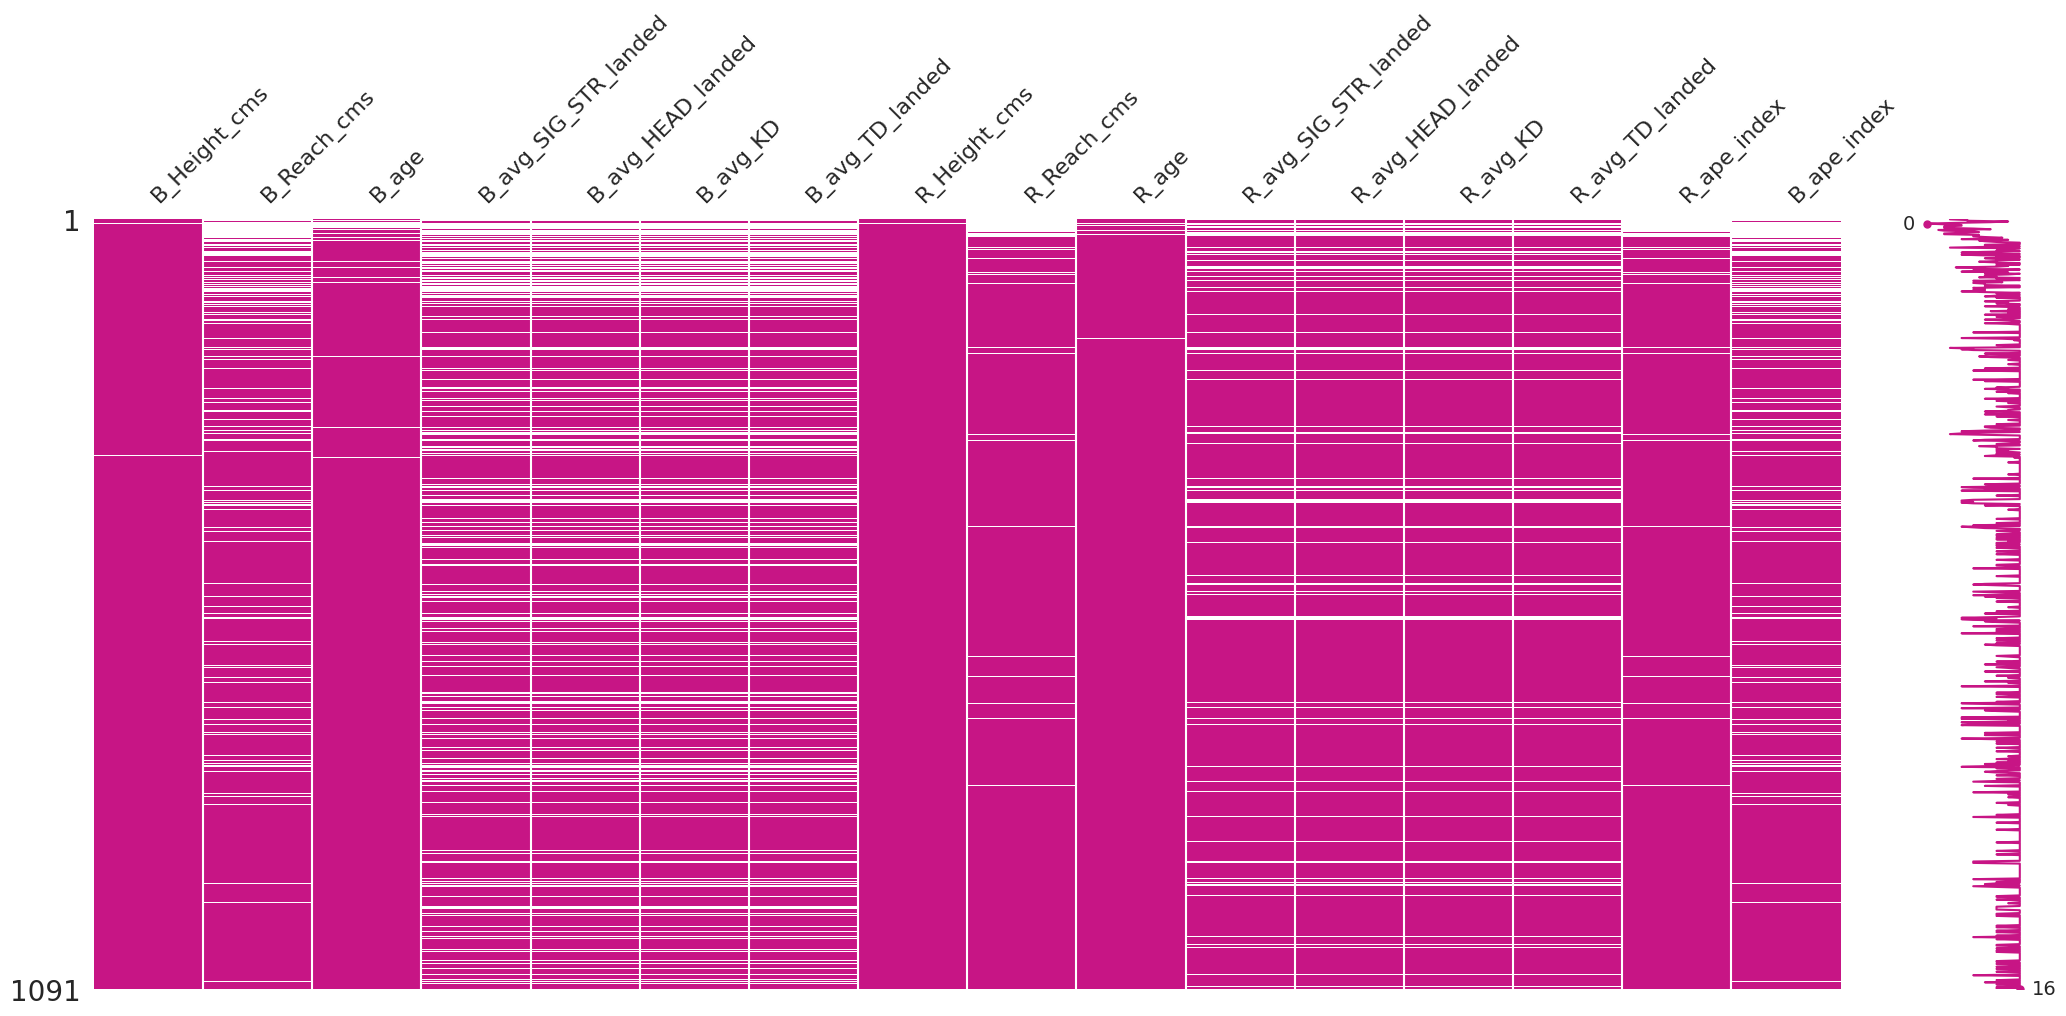

In [36]:
lightweights_df = lightweights_df.sort_values(by='date', ascending=True)
columns_with_na = lightweights_df.columns[lightweights_df.isna().any()].tolist()

# Print the columns with missing values
print("Columns with NA values:", columns_with_na)

lightweights_na_columns = lightweights_df[columns_with_na]

dark_pink_rgb = mcolors.hex2color('#c71585')
# Visualize missing data for these columns
msno.matrix(lightweights_na_columns, color=dark_pink_rgb)

# plt.savefig('missing_data_matrix.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

Considering Height, Age and Especially Reach, it does seem that old data is more likely to have missing values.
It is plausible that old measurements were lost, or in case of Reach, its measurement was not as common.

For fighter stats based on previous matches, namely average Significant strikes (`avg_SIG_STR_landed`), average Head strikes (`avg_HEAD_landed`), average Knockdowns (`avg_KD`) and Takedowns (`avg_TD_landed`), missing values are due to the fact that there is no past data for first time fighters.

This becomes evident when sampling all matches of a single fighter, minding that he/she may have started his/her career in another weight class.

Let's take, for instance, Clay Guida:


In [35]:
clay_guida=lightweights_df[
    (lightweights_df['R_fighter']=='Clay Guida') | (lightweights_df['B_fighter']=='Clay Guida')
    ][['R_fighter', 'B_fighter', 'date', 'R_avg_SIG_STR_landed', 'R_avg_HEAD_landed', 'R_avg_KD', 'R_avg_TD_landed', 'B_avg_SIG_STR_landed', 'B_avg_HEAD_landed', 'B_avg_KD', 'B_avg_TD_landed']]
clay_guida.head(10)

,R_fighter,B_fighter,date,R_avg_SIG_STR_landed,R_avg_HEAD_landed,R_avg_KD,R_avg_TD_landed,B_avg_SIG_STR_landed,B_avg_HEAD_landed,B_avg_KD,B_avg_TD_landed
72,Michael Johnson,Clay Guida,2021-02-06,45.896618,21.914445,2.096653e-03,0.071718,24.516304,13.523838,0.039551,1.673881
402,Clay Guida,Bobby Green,2020-06-20,26.032609,17.047675,7.910168e-02,0.347762,71.005859,34.467773,0.000977,1.444336
787,Jim Miller,Clay Guida,2019-08-03,8.427192,5.003186,1.303852e-07,1.259079,50.065218,33.095350,0.158203,0.695524
912,BJ Penn,Clay Guida,2019-05-11,19.507738,15.637308,2.540284e-01,0.035456,20.130436,14.190701,0.316407,0.391049
1374,Clay Guida,Charles Oliveira,2018-06-09,31.260872,24.381402,6.328135e-01,0.782098,8.935654,4.784252,0.007828,2.056114
1651,Joe Lauzon,Clay Guida,2017-11-11,38.141161,34.185519,6.253064e-02,3.154822,38.521743,28.762804,0.265627,1.564196
1822,Clay Guida,Erik Koch,2017-06-25,39.043486,24.525607,5.312538e-01,1.128391,14.000000,9.859375,0.140625,1.000000
4052,Gray Maynard,Clay Guida,2012-06-22,44.803711,38.048828,1.252930e+00,1.564453,14.132507,6.555420,0.000977,2.868103
4264,Clay Guida,Benson Henderson,2011-11-12,17.265015,9.110840,1.953125e-03,3.736206,60.500000,33.000000,0.000000,5.000000
4406,Clay Guida,Anthony Pettis,2011-06-04,15.530029,10.221680,3.906250e-03,2.472412,NaN,NaN,NaN,NaN


It is possible to see that his first fight, in 2006-10-14 had `NaN` in all fighter statistics. Same applies for his opponent, suggesting this was a match between first-time UFC participants.

Also, as confirmed in the missingno matrix above, `NaN` occurs at the same location for all four past statistics columns.

One thing to note is that missing values for these four columns are much more frequent for Blue fighters (263 `NaN`s) than for Red (109 `NaN`s). Combined with the fact that `NaN`s are due to a fighter being a new participant, this suggests a potential bias in color assignment that will be discussed further in the Exploration section.

## Handling Null Values

In our dataset, we have identified different patterns of missing data:

MCAR (Missing Completely at Random):
Definition: The missingness of data is independent of both observed and unobserved data.
Example: The small number of missing values in `B_Height_cms` (4) and `R_Height_cms` (1) might be due to random data entry errors.

MAR (Missing at Random):
Definition: The propensity for a data point to be missing is not related to the missing data, but it is related to some of the observed data.
Example: The missing values in `B_Reach_cms` (159) and `R_Reach_cms` (47) could be MAR. If older records are less likely to have reach data, the missingness is related to the date, but not directly to reach itself.

MNAR (Not Missing at Random):
This is the case for `avg_SIG_STR_landed`, `avg_HEAD_landed`, `avg_KD` and `avg_TD_landed`, that have systematic reason for being missing.

To salvage these, an approach would to take the minimum value for all future
fights of an athlete, under the conservative assumption that a fighter performs
worse when he is just at the beginning of his UFC career.  
However, when we looked at the results, we realized that the median shifted a lot downwards and would alter our results. Also, our model would have been trained on matches with stats that may not reflect reality.  

Consequently, we decided to instead remove the null values, but still continue to use those variables since we expect them to be useful.

Furthermore, we have done an interesting observation about the discrepancy in missing values between Blue and Red fighters, suggesting a systematic pattern where new fighters (often assigned as Blue fighters) are more likely to have missing historical performance data. This pattern falls under MNAR, as the missingness is directly related to the nature of the data itself (i.e., new fighters not having historical data). Understanding these patterns is crucial for choosing appropriate methods to handle missing data in your analysis, such as imputation or exclusion.

In [ ]:
# remove null values
lightweights_df = lightweights_df.dropna()

In [34]:
# show null values after dropping
null_values_lightweights = lightweights_df.isnull().sum()
print("Null Values in the 'Lightweight' weight class:")
print(null_values_lightweights)

Null Values in the 'Lightweight' weight class:
R_fighter                  0
B_fighter                  0
Winner                     0
weight_class               0
date                       0
B_total_rounds_fought      0
B_current_win_streak       0
B_current_lose_streak      0
B_wins                     0
B_longest_win_streak       0
B_losses                   0
B_Height_cms               4
B_Reach_cms              159
B_age                     29
B_avg_SIG_STR_landed     263
B_avg_HEAD_landed        263
B_avg_KD                 263
B_avg_TD_landed          263
R_total_rounds_fought      0
R_current_win_streak       0
R_current_lose_streak      0
R_wins                     0
R_longest_win_streak       0
R_losses                   0
R_Height_cms               1
R_Reach_cms               47
R_age                      6
R_avg_SIG_STR_landed     109
R_avg_HEAD_landed        109
R_avg_KD                 109
R_avg_TD_landed          109
R_ape_index               47
B_ape_index              

after the dropna we realized that we went from around 1000 metches to 735 and we will continue our analysis with this column number




In [33]:
lightweights_df.describe().T

,count,mean,std,min,25%,50%,75%,max
B_total_rounds_fought,1091.0,10.141155,13.004454,0.00,1.000000,6.000000,14.000000,86.000000
B_current_win_streak,1091.0,0.841430,1.308956,0.00,0.000000,0.000000,1.000000,7.000000
B_current_lose_streak,1091.0,0.430797,0.676964,0.00,0.000000,0.000000,1.000000,5.000000
B_wins,1091.0,2.692942,3.604551,0.00,0.000000,1.000000,4.000000,23.000000
B_longest_win_streak,1091.0,1.626031,1.760270,0.00,0.000000,1.000000,3.000000,8.000000
B_losses,1091.0,1.656279,2.110721,0.00,0.000000,1.000000,2.000000,14.000000
B_Height_cms,1087.0,176.746145,4.891668,160.02,172.720000,177.800000,180.340000,193.040000
B_Reach_cms,932.0,181.471009,5.593063,162.56,177.800000,180.340000,185.420000,203.200000
B_age,1062.0,28.625235,3.673894,18.00,26.000000,28.500000,31.000000,40.000000
B_avg_SIG_STR_landed,828.0,32.652425,20.632936,0.00,18.000000,30.000000,43.375000,131.739330


# Exploration - EDA

### Corner color relationships
Our modeling goal will be predicting the outcome of a fight.  
Between our features though, color is not randomly assigned, but rather determined by the promotion company.  
In this section we investigate whether there is systematic bias in assigning color and assess if this will influence our model.

We start by subsetting the dataset to include only:
- Quantitative variables related to actions that can define the outcome of a fight based on common ways of victory explored previously:
  Head strikes, Significant strikes, Takedowns and Knockdowns
- Career stats of the fighters:
  victories, current and longest victory streak, how many rounds the athlete has fought in total
- Physical characteristics of fighters:
  height, reach (i.e. armspan)

Since the fighters are grouped in weight classes, weight will not be considered as its variation within a class is small.

Another measurement often taken into account in sports is the so called 'Ape index', which expresses the difference or ratio between reach and height.  
A high ape index signifies either long arms in relation to height, or short height compared to arm span, therefore rendering the subject more akin to a primate.  
In martial arts, a high ape index is considered beneficial.

In our exploration and modeling, we will compute the ape index as the difference between reach and height (in cm) of a fighter.

First, it is worth noting that Red fighters seem to win more, on average, than Blue fighters, as shown in the plot below:

Red victory percentage:  61.4 %
Blue victory percentage:  36.6 %


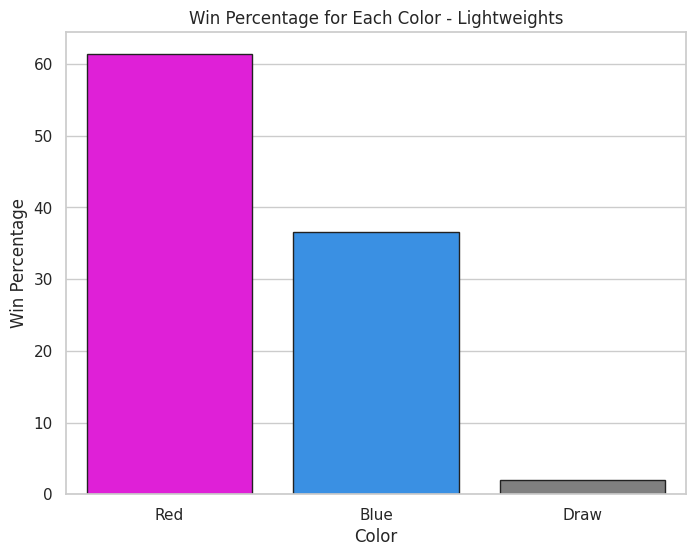

In [ ]:
win_counts = lightweights_df['Winner'].value_counts()
total_matches = win_counts.sum()
win_percentages = (win_counts / total_matches) * 100

plt.figure(figsize=(8, 6))
palette= {'Red':  '#ff00f4', 'Blue': 'dodgerblue', 'Draw': '#808080'}
sns.set_theme(style='whitegrid')
sns.barplot(x=win_percentages.index, y=win_percentages.values, palette=palette, edgecolor='#222222')
plt.title('Win Percentage for Each Color - Lightweights')
plt.xlabel('Color')
plt.ylabel('Win Percentage')

#plt.savefig('win_type_percent.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

print('Red victory percentage: ', round(win_percentages[0],1),'%')
print('Blue victory percentage: ', round(win_percentages[1],1),'%')

We then compute the Ape index.  
Even though this is more of a preprocessing step for our model, it will still be interesting to visualize the distribution of this feature.

In [20]:
lightweights_df['R_ape_index']=lightweights_df['R_Reach_cms']-lightweights_df['R_Height_cms']
lightweights_df['B_ape_index']=lightweights_df['B_Reach_cms']-lightweights_df['B_Height_cms']

#### Tidying
To use the '`hue`' argument of the plotting functions, we need first to reshape the dataframe to a tidy format:  
- The same feature column for each fighter will be concatenated stored in a single column. To do this, it will first need to be cast into a list, then put into a dictionary
- A corner color column will be added.
- The new tidy dictionary will be converted to a dataframe

In [21]:
reshaped_data = {
    'Rounds fought': lightweights_df['R_total_rounds_fought'].tolist() + lightweights_df['B_total_rounds_fought'].tolist(),
    'Current win streak': lightweights_df['R_current_win_streak'].tolist() + lightweights_df['B_current_win_streak'].tolist(),
    'Longest win streak': lightweights_df['R_longest_win_streak'].tolist() + lightweights_df['B_longest_win_streak'].tolist(),
    'Victories': lightweights_df['R_wins'].tolist() + lightweights_df['B_wins'].tolist(),
    'Avg Head Strikes': lightweights_df['R_avg_HEAD_landed'].tolist() + lightweights_df['B_avg_HEAD_landed'].tolist(),
    'Avg Significant Strikes': lightweights_df['R_avg_SIG_STR_landed'].tolist() + lightweights_df['B_avg_SIG_STR_landed'].tolist(),
    'Avg knockdowns': lightweights_df['R_avg_KD'].tolist() + lightweights_df['B_avg_KD'].tolist(),
    'Avg takedowns': lightweights_df['R_avg_TD_landed'].tolist() + lightweights_df['B_avg_TD_landed'].tolist(),
    'Reach (cm)': lightweights_df['R_Reach_cms'].tolist() + lightweights_df['B_Reach_cms'].tolist(),
    'Height (cm)': lightweights_df['R_Height_cms'].tolist() + lightweights_df['B_Height_cms'].tolist(),
    'Ape index (cm)': lightweights_df['R_ape_index'].tolist() + lightweights_df['B_ape_index'].tolist(),
    'Age': lightweights_df['R_age'].tolist() + lightweights_df['B_age'].tolist(),
    'Corner': ['Red'] * len(lightweights_df) + ['Blue'] * len(lightweights_df) # adding the corner color variable
}

reshaped_df = pd.DataFrame(reshaped_data) # cast the dictionary back into a dataframe

In [23]:
reshaped_df.head()

,Rounds fought,Current win streak,Longest win streak,Victories,Avg Head Strikes,Avg Significant Strikes,Avg knockdowns,Avg takedowns,Reach (cm),Height (cm),Ape index (cm),Age,Corner
0,18,1,6,7,32.281250,42.18750,0.31250,0.632812,190.50,182.88,7.62,41.0,Red
1,15,0,3,4,58.656250,67.87500,0.25000,0.031250,182.88,177.80,5.08,25.0,Red
2,17,1,6,7,20.085938,27.87500,0.56250,1.367188,177.80,177.80,0.00,29.0,Red
3,0,0,0,0,NaN,NaN,NaN,NaN,180.34,185.42,-5.08,27.0,Red
4,12,2,2,4,16.781250,30.65625,0.53125,0.875000,182.88,175.26,7.62,28.0,Red


In [24]:
print(reshaped_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rounds fought            2182 non-null   int64  
 1   Current win streak       2182 non-null   int64  
 2   Longest win streak       2182 non-null   int64  
 3   Victories                2182 non-null   int64  
 4   Avg Head Strikes         1810 non-null   float64
 5   Avg Significant Strikes  1810 non-null   float64
 6   Avg knockdowns           1810 non-null   float64
 7   Avg takedowns            1810 non-null   float64
 8   Reach (cm)               1976 non-null   float64
 9   Height (cm)              2177 non-null   float64
 10  Ape index (cm)           1974 non-null   float64
 11  Age                      2147 non-null   float64
 12  Corner                   2182 non-null   object 
dtypes: float64(8), int64(4), object(1)
memory usage: 221.7+ KB
None


In [25]:
reshaped_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rounds fought,2182.0,12.667736,14.155715,0.00,2.250000,8.000000,18.000000,86.000000
Current win streak,2182.0,1.035289,1.454851,0.00,0.000000,0.000000,2.000000,12.000000
Longest win streak,2182.0,1.997250,1.936164,0.00,0.000000,2.000000,3.000000,13.000000
Victories,2182.0,3.395967,3.886272,0.00,0.000000,2.000000,5.000000,23.000000
Avg Head Strikes,1810.0,21.298814,14.943150,0.00,11.475098,18.417969,27.623047,173.163765
Avg Significant Strikes,1810.0,33.593824,21.176596,0.00,19.015015,30.000000,44.000000,212.142956
Avg knockdowns,1810.0,0.208729,0.318664,0.00,0.000000,0.016479,0.312500,2.373047
Avg takedowns,1810.0,1.278299,1.353962,0.00,0.250000,1.000000,1.995117,10.875000
Reach (cm),1976.0,181.374767,5.605525,162.56,177.800000,180.340000,185.420000,203.200000
Height (cm),2177.0,176.684593,4.869066,160.02,172.720000,177.800000,180.340000,193.040000


The tidy dataframe, '`reshaped_df`', is now ready for plotting.
After the dropna we had 735 matches in `lightweights_df`.  
Setting them up into tidy format results in 1470 entries.  

Since the features are 12, we opted to make four 2x2 subplots.  

The method of visualization chosen is a violin plot, since it elegantly displays the distribution of a single feature while also computing the mean and rmsm allowing for easy comparison.  
Note than we set '`cut=0`' in '`sns.violinplot`' so that the plotted variable range correponds to the actual data.  

To shorten the code, we incorporated the necessary commands into a function that takes as argument a list of four features to plot and the color palette.  
The same is done for a function that prints the mean for both distributions.

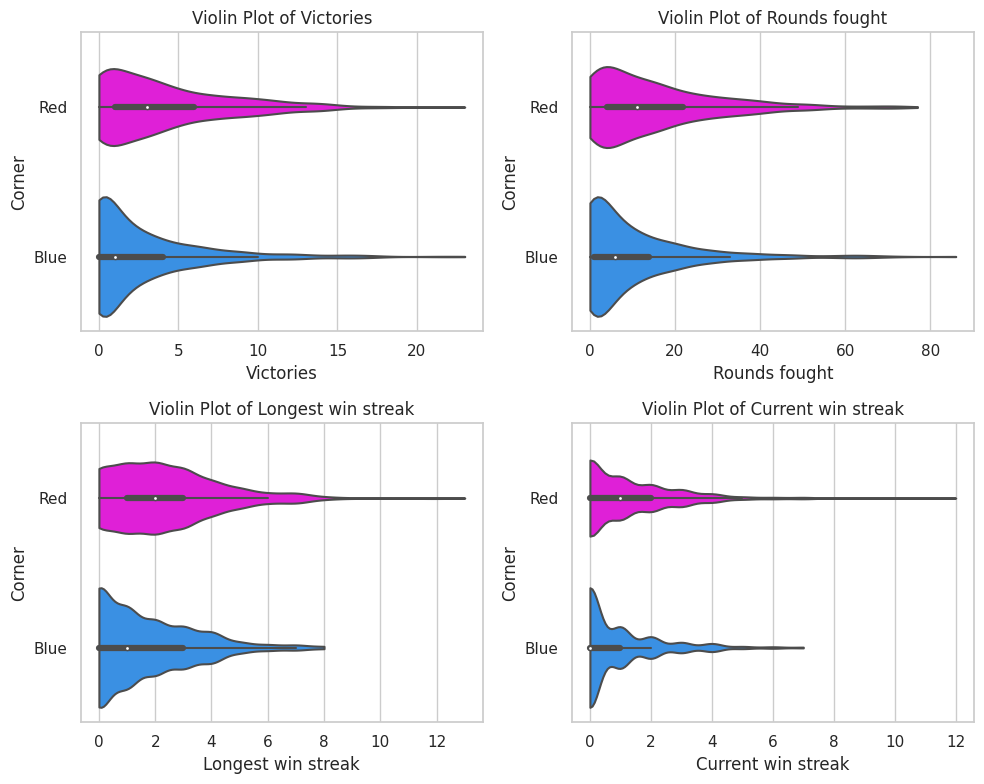

Mean of Red Victories : 4.1
Mean of Blue Victories : 2.7
Mean of Red Rounds fought : 15.2
Mean of Blue Rounds fought : 10.1
Mean of Red Longest win streak : 2.4
Mean of Blue Longest win streak : 1.6
Mean of Red Current win streak : 1.2
Mean of Blue Current win streak : 0.8


In [26]:
# Since we will be doing this with multiple feature subsets, we enclose it in a function to make the
# following code shorter
# We are now creating a figure with 2x2 subplots, iterates over the feature list and plots them

def plot2by2(features, palette):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # Nested loops for rows and columns of the plot and an index that loops over the feature subset
    feature_index = 0
    for i in range(2):
        for j in range(2):
            if feature_index < len(features):
                sns.violinplot(data=reshaped_df, y='Corner', x=features[feature_index], ax=axes[i, j], palette=palette, cut=0, bbox_inches='tight', pad_inches=0.1)
                axes[i, j].set_title('Violin Plot of ' + features[feature_index])
                feature_index += 1

    plt.tight_layout()
    plt.savefig('4by4_violins.png', transparent=True)
    plt.show()

def printmean(features):
  for feature in features:
    print('Mean of Red '+feature+' : '+str(round(reshaped_df[reshaped_df['Corner'] == 'Red'][feature].mean(), 1)))
    print('Mean of Blue '+feature+' : '+str(round(reshaped_df[reshaped_df['Corner'] == 'Blue'][feature].mean(), 1)))

features = ['Victories', 'Rounds fought', 'Longest win streak', 'Current win streak']
palette = {'Red':  '#ff00f4', 'Blue': 'dodgerblue'}
sns.set_theme(style="whitegrid")
plot2by2(features, palette)
printmean(features)
# plt.savefig('violin.plot.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

Above, it is possible to observe a potential bias of color assignment.
The distributions of:  
- Total number of victories
- Total number of rounds fought
- Longest win streak  

display a net difference between Blue and Red corner fighters, both in terms of mean, mode and median.  
Note how the minimum rounds fought is 1, since we dropped all entries of first time fighters.

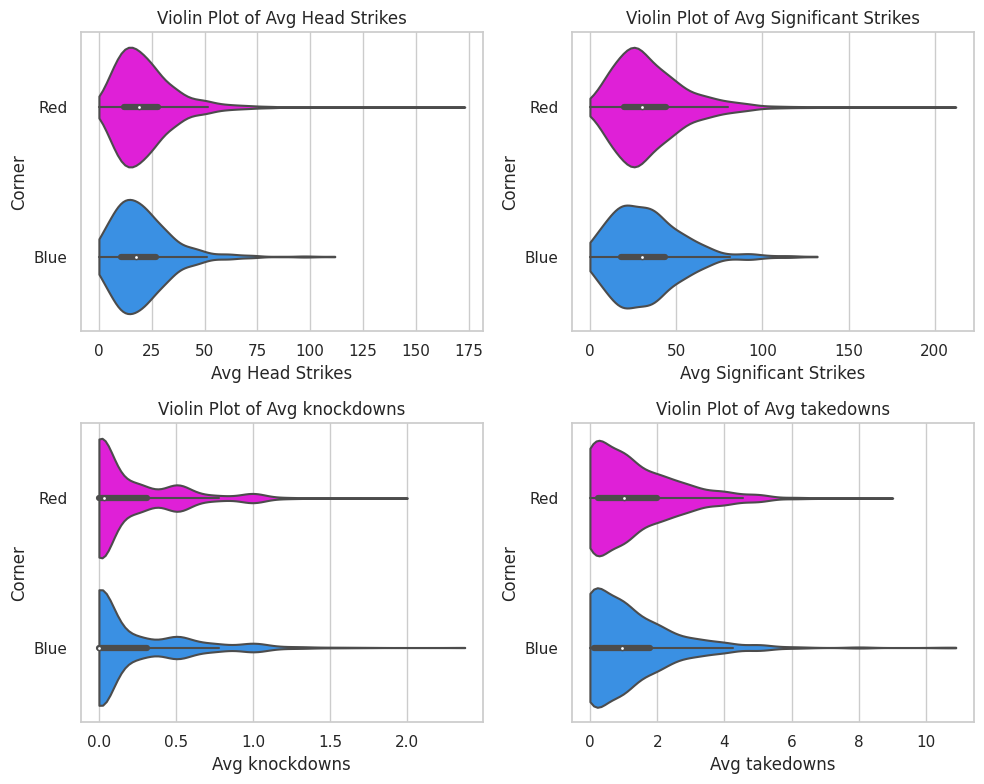

Mean of Red Avg Head Strikes : 21.9
Mean of Blue Avg Head Strikes : 20.5
Mean of Red Avg Significant Strikes : 34.4
Mean of Blue Avg Significant Strikes : 32.7
Mean of Red Avg knockdowns : 0.2
Mean of Blue Avg knockdowns : 0.2
Mean of Red Avg takedowns : 1.3
Mean of Blue Avg takedowns : 1.2


In [27]:
features = ['Avg Head Strikes','Avg Significant Strikes','Avg knockdowns','Avg takedowns']
plot2by2(features, palette)
printmean(features)

When considering more objective performance features, namely:
- The average number of strikes to the head landed in previous fights
- The average number of significant strikes landed
- The average number of knockdowns
- The average number of takedowns

The difference between Red and Blue fighters is minimal.

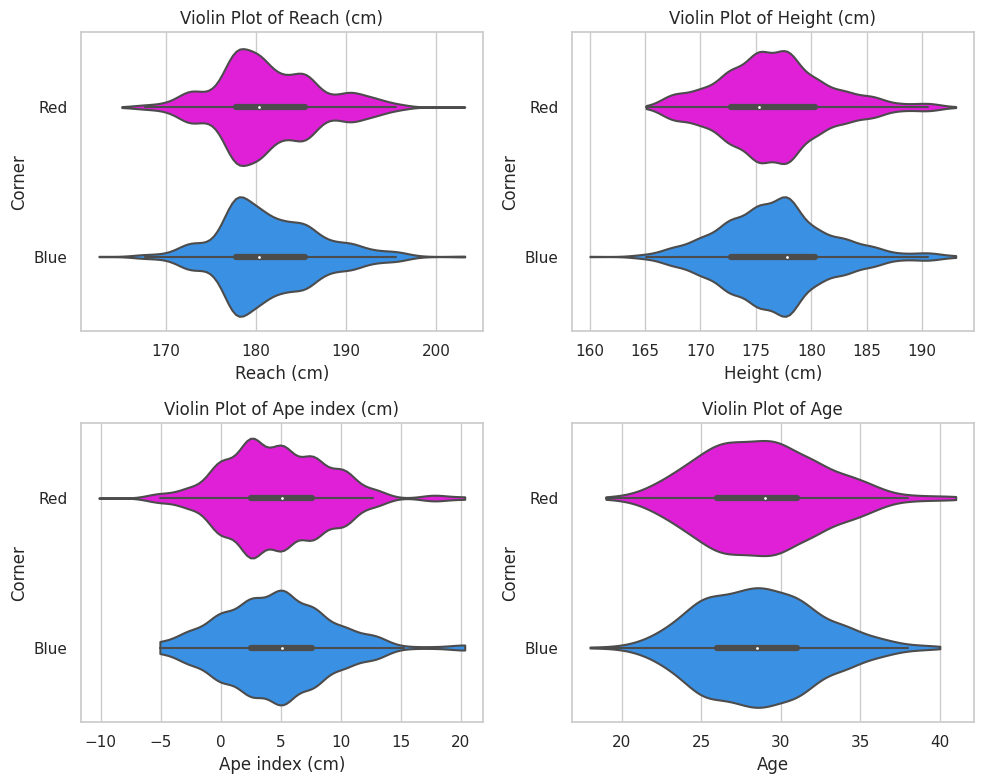

Mean of Red Reach (cm) : 181.3
Mean of Blue Reach (cm) : 181.5
Mean of Red Height (cm) : 176.6
Mean of Blue Height (cm) : 176.7
Mean of Red Ape index (cm) : 4.7
Mean of Blue Ape index (cm) : 4.6
Mean of Red Age : 28.8
Mean of Blue Age : 28.6
Median of Red Height : 175.3
Median of Blue Height : 177.8


In [28]:
features = ['Reach (cm)','Height (cm)','Ape index (cm)','Age']
plot2by2(features, palette)
printmean(features)

print('Median of Red Height : '+str(round(reshaped_df[reshaped_df['Corner'] == 'Red']['Height (cm)'].median(), 1)))
print('Median of Blue Height : '+str(round(reshaped_df[reshaped_df['Corner'] == 'Blue']['Height (cm)'].median(), 1)))

When considering the physical characteristics of fighers, again the two colors' distributions seem again to mirror each other, the only exception being the median height of Blue fighters being ~2.5 higher than Red ones due outliers.


We therefore conclude that, on average the red corner is assigned to UFC athletes with more experience in terms of rounds and match victories.  
Instead, other match performance statistics of physical characteristics are not direclty seem related to color

## Heatmaps

To observe the relationships within our data, we created a few correlation matrices.

This allows us to spot potential useful relationships within features, which by now are all quantitative.  
It will also help in deciding what kind of model to use for victory prediction, and identify potential multicollinearities.

Let us start with correlation between all features, regardless of fighter color.  
Then, we will treat Blue and Red separately and examine the differences.

Text(0.5, 1.0, 'Correlation Matrix for Lightweight Fighters Features')

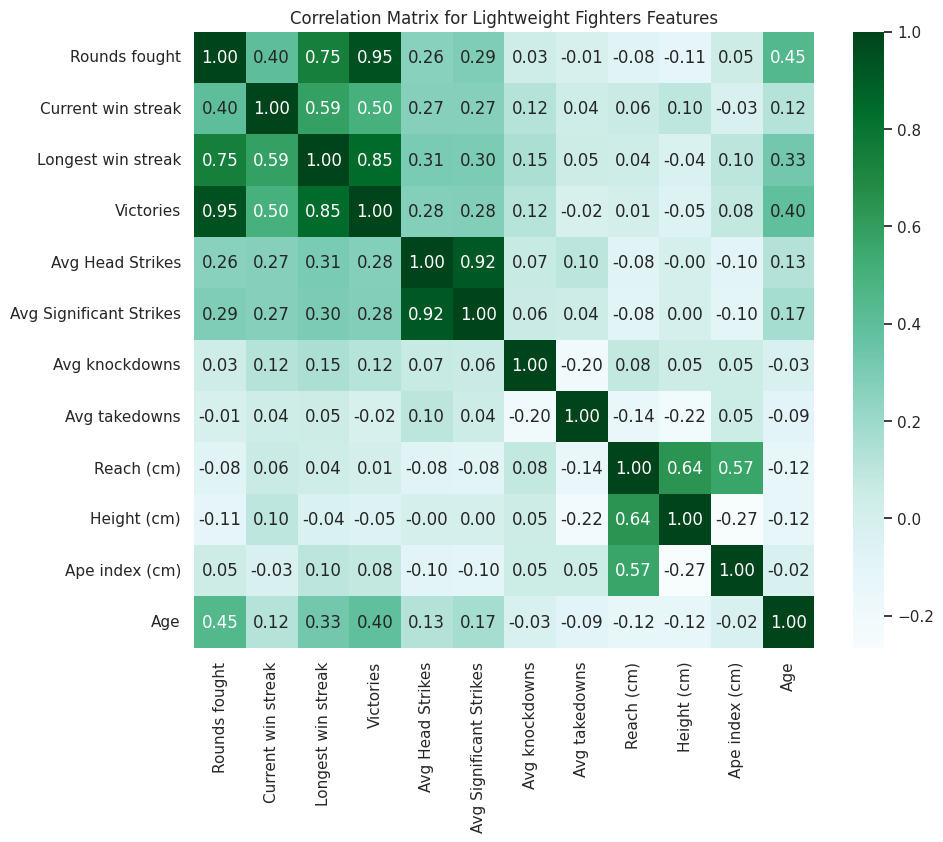

In [29]:
plt.figure(figsize=(10, 8))

correlation_matrix = reshaped_df.corr(numeric_only=True)

sns.heatmap(correlation_matrix, cmap='BuGn', annot=True, fmt=".2f")
plt.title('Correlation Matrix for Lightweight Fighters Features')

# plt.savefig('correlation.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

From this correlation matrix, we desume that no particularly strong correlations are evident for victories and victory streaks, besides trivial ones, such as:
- Number of rounds fought being correlated to longest win streak and victories
- Current win streak correlated to longest win streak
- Longest win streak being related to victories
- Significant strikes to the head being related to total number of significant strikes
- Height, reach and ape index being correlated

Text(0.5, 1.0, 'Correlation Matrix for Blue Fighter Features')

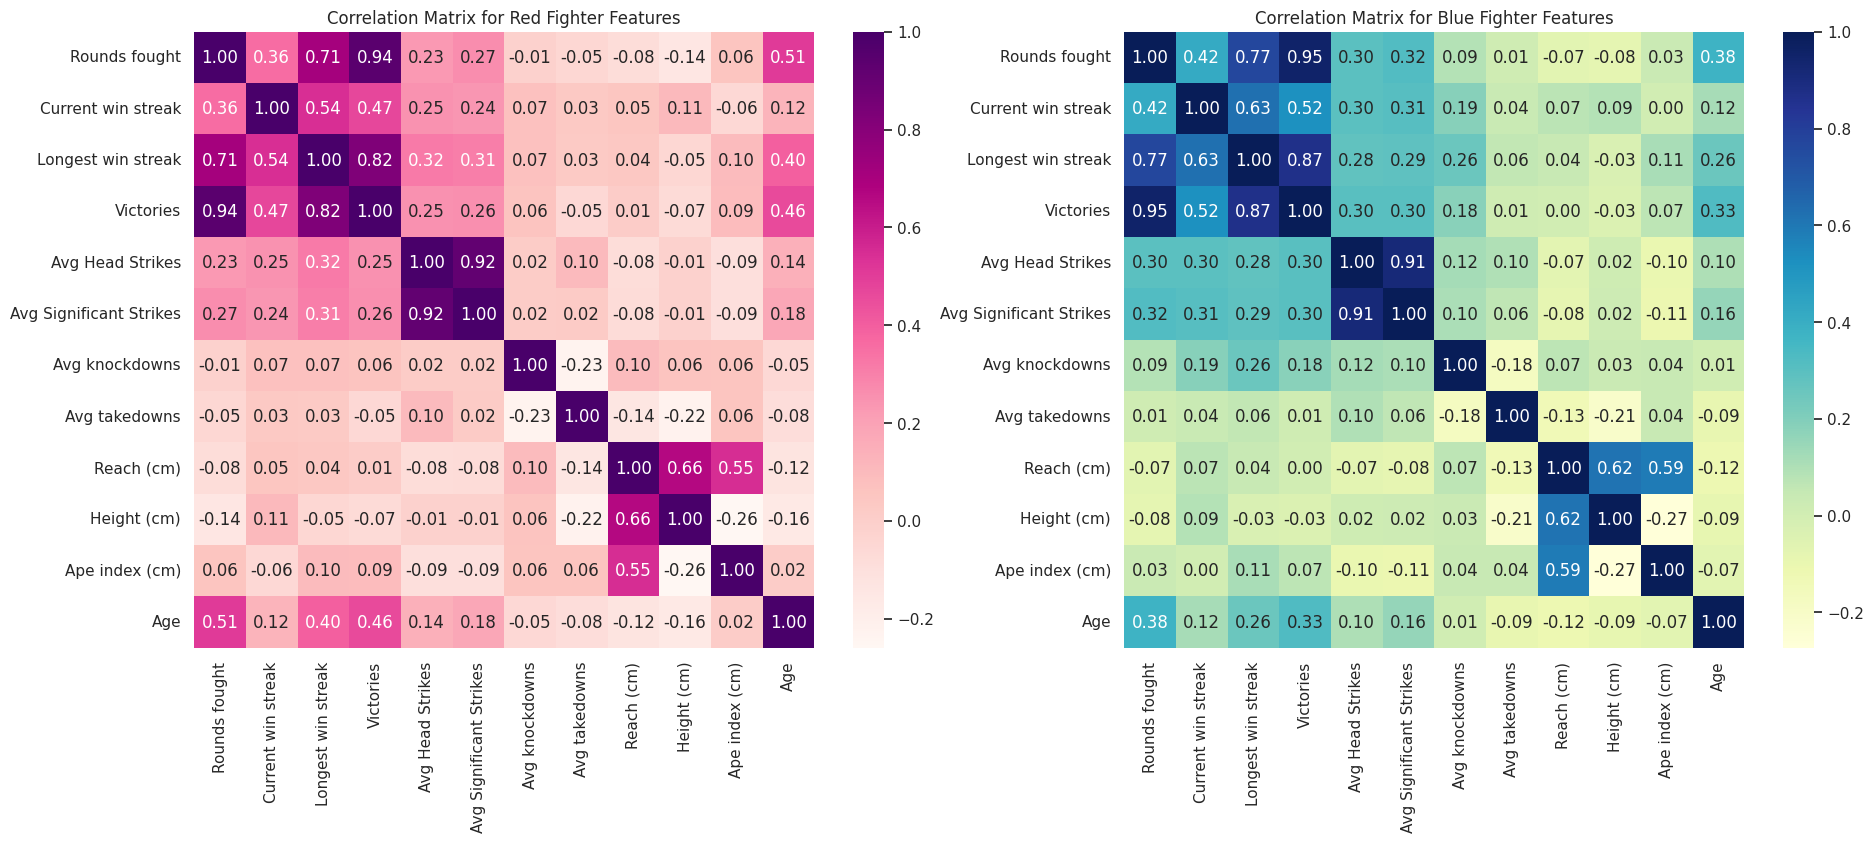

In [30]:
correlation_matrix_R = reshaped_df[reshaped_df['Corner']=='Red'].corr(numeric_only=True)
correlation_matrix_B = reshaped_df[reshaped_df['Corner']=='Blue'].corr(numeric_only=True)

fig, axs = plt.subplots(1, 2, figsize=(22, 8))
sns.heatmap(correlation_matrix_R, cmap="RdPu", annot=True, fmt=".2f", ax=axs[0])
axs[0].set_title('Correlation Matrix for Red Fighter Features')
sns.heatmap(correlation_matrix_B, cmap="YlGnBu", annot=True, fmt=".2f", ax=axs[1])
axs[1].set_title('Correlation Matrix for Blue Fighter Features')

# plt.savefig('R_B_correlations.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

Text(0.5, 1.0, 'Difference between Red and Blue Fighter Feature Correlations')

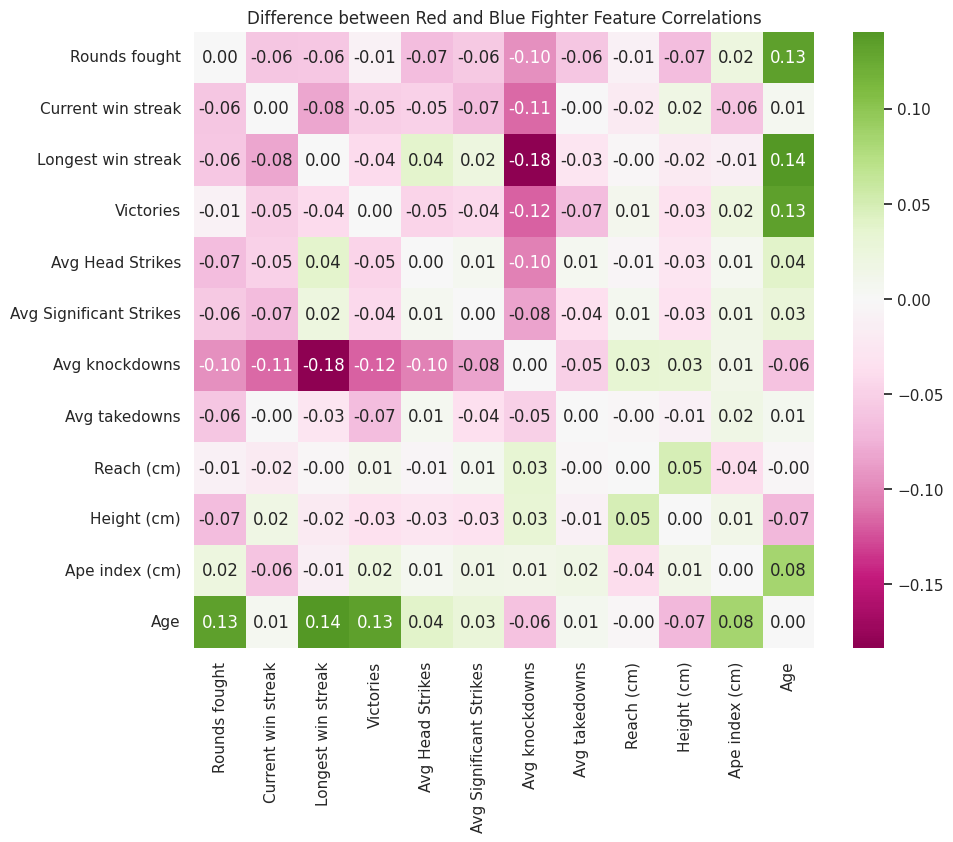

In [31]:
correlation_difference = correlation_matrix_R - correlation_matrix_B

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_difference, cmap="PiYG", center=0, annot=True, fmt=".2f")
plt.title('Difference between Red and Blue Fighter Feature Correlations')

# plt.savefig('correlations_diff.png', transparent=True, bbox_inches='tight', pad_inches=0.1)

The correlation matrices for each color display the same general patterns.

It is worth noting that reds seem to have a stronger correlation than blues between age and victories, and age and longest win streak.  

Curiously, blue fighters seem to feature a stronger correlation between average knowdowns and victories and win streaks, as well as between knockdowns and number of strikes.

We conclude that a regression between quantitative features to predict number of victories or win streak would not be a productive approach.

### Feature distributions

The following snippet code is useful for quickly visualizing the distributions of numeric variables in our dataframe.


Text(0.5, 0.95, 'Insights into the Numeric Variable Distributions')

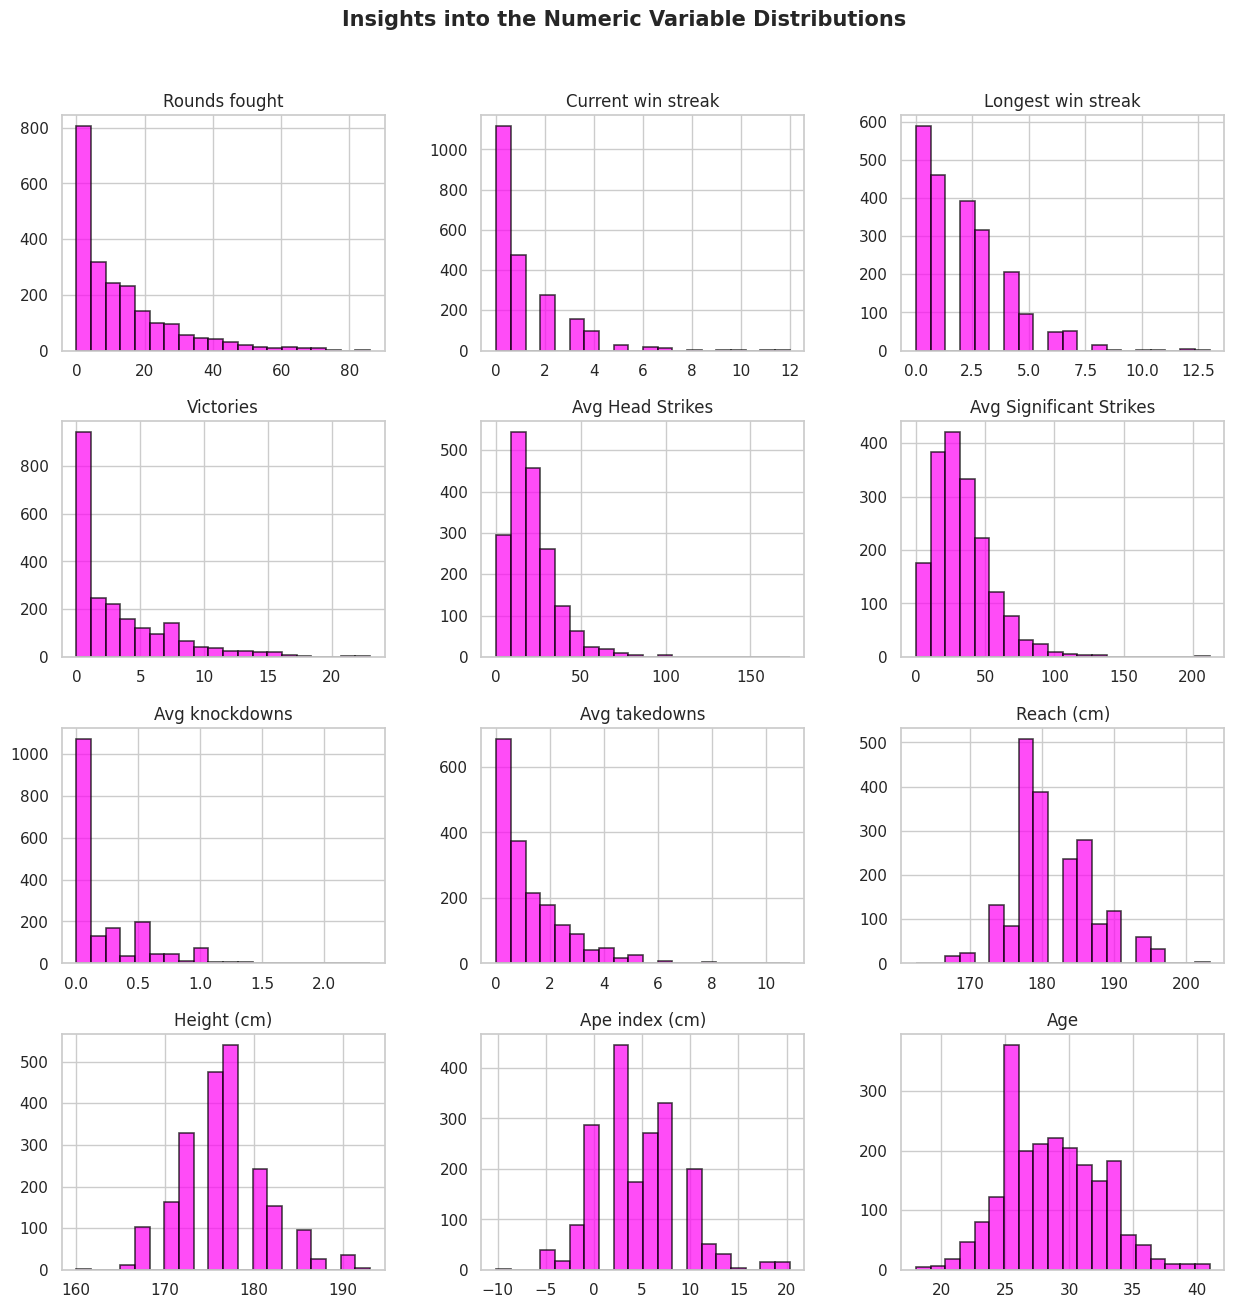

In [32]:
numerical_columns = reshaped_df.select_dtypes(include=['float64', 'int64']).columns

reshaped_df[numerical_columns].hist(bins=20, figsize=(15, 15), color="#ff00f4", edgecolor='black', linewidth=1.2, alpha=0.7)
sns.set_theme(style="whitegrid")
plt.suptitle("Insights into the Numeric Variable Distributions", y=0.95, fontsize=15, weight='bold'  )

# Conclusions

Now that we have completed our EDA on Python, we decided to conduct on Rstudio the modelling implementation and the evaluation.
Our ultimate goal is predicting the match victories.

From our scrubbing and explorative analysis, we can make three conclusions:
*   null value handling: null values follow a systematic pattern for past statistics such as avarage significant strikes. That is, they occur for first time fighters. They are also more frequent for blue fighters which starts to suggest a potential bias in color assignment.
*   exploring color bias: we have confirmed that UFC fighters' corner color is not assigned at random but is related to experience and popularity related feature, such as the total amount of round fought, longest win streak, total victories.
*   from the correlation matrices: we deduced that there are no significant relationships with the quantitative variables. Therefore, we must employ classification methods for victory prediction. Since victory is a binary response variable, it will be a textbook applicatin for logistic regression.

In the R notebook, which should be considered complementary to this Python notebook, we will go more in depth into data preprocessing and scaling, while also further exploring relationships between features and corner color.  
The logistic regression model will be trained, tested and evaluated based on metrics such as classification accuracy, sensitivity, specificity and informedness. To further evaluate it, we will also perform 5-fold cross-validation.